In [6]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib
import matplotlib.pyplot as plt
from classes.credentials import Credentials as cr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
valeurs2019 = pd.read_csv(cr.PATH+'2019.txt', sep='|', encoding='utf-8')

C:\Users\utilisateur\anaconda3\envs\data-science\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (18,23,24,26,28,29,31,33,41) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Informations dataset d'origine

In [8]:
valeurs2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2535791 entries, 0 to 2535790
Data columns (total 43 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   Code service CH             float64
 1   Reference document          float64
 2   1 Articles CGI              float64
 3   2 Articles CGI              float64
 4   3 Articles CGI              float64
 5   4 Articles CGI              float64
 6   5 Articles CGI              float64
 7   No disposition              int64  
 8   Date mutation               object 
 9   Nature mutation             object 
 10  Valeur fonciere             object 
 11  No voie                     float64
 12  B/T/Q                       object 
 13  Type de voie                object 
 14  Code voie                   object 
 15  Voie                        object 
 16  Code postal                 float64
 17  Commune                     object 
 18  Code departement            object 
 19  Code commune         

## Première suppression des colonnes inutilisées. 

In [21]:
filteredValeurs2019 = valeurs2019[['Nature mutation', 'Code postal','Nombre pieces principales', 'Surface terrain', 'Surface Carrez du 1er lot', 'Surface Carrez du 2eme lot', 'Surface Carrez du 3eme lot', 'Surface Carrez du 4eme lot', 'Surface Carrez du 5eme lot', 'Valeur fonciere', 'Type local', 'Nombre de lots', 'No voie']]

## Vérification des valeurs nulles en vue de les supprimer (ou non)

In [10]:
columns = filteredValeurs2019.columns
for index in columns :
    nancount = filteredValeurs2019[index].isna()
    print("Nombre de lignes nulles dans la colonne", index, " : ", nancount.sum())


Nombre de lignes nulles dans la colonne Nature mutation  :  0
Nombre de lignes nulles dans la colonne Code postal  :  28323
Nombre de lignes nulles dans la colonne Nombre pieces principales  :  1184176
Nombre de lignes nulles dans la colonne Surface terrain  :  792958
Nombre de lignes nulles dans la colonne Surface Carrez du 1er lot  :  2314726
Nombre de lignes nulles dans la colonne Surface Carrez du 2eme lot  :  2481517
Nombre de lignes nulles dans la colonne Surface Carrez du 3eme lot  :  2530577
Nombre de lignes nulles dans la colonne Surface Carrez du 4eme lot  :  2534376
Nombre de lignes nulles dans la colonne Surface Carrez du 5eme lot  :  2535182
Nombre de lignes nulles dans la colonne Valeur fonciere  :  29261
Nombre de lignes nulles dans la colonne Type local  :  1182459
Nombre de lignes nulles dans la colonne Nombre de lots  :  0
Nombre de lignes nulles dans la colonne No voie  :  1025638


On peut donc supprimer les codes postaux nuls (petit pourcentage), les surfaces carrez nulles, qui représentent la quasi totalité du dataset, les valeurs foncières nulles étant donné que c'est notre valeur cible. Nous verrons plus tard pour les types de locaux nuls (beaucoup de valeurs), le nombre de pièces principales, la surface du terrain (vérifier si lorsqu'il n'y a pas de terrain, la valeur est bien égale à 0 et pas nulle). Nous gardons le No voie.

## Vérifications supplémentaires 

In [11]:
withoutSurface = filteredValeurs2019[['Surface terrain']][filteredValeurs2019['Surface terrain']==0]
print('Surfaces terrain égales à 0 : ', len(withoutSurface))

withoutPieces = filteredValeurs2019[['Nombre pieces principales']][filteredValeurs2019['Nombre pieces principales']==0]
print('Nombre de pièces principales égales à 0 : ', len(withoutPieces))

DependenciesWoPiece = filteredValeurs2019[['Nombre pieces principales']][filteredValeurs2019['Nombre pieces principales']==0][filteredValeurs2019['Type local']=='Dépendance']
print('Nombre de pièces principales égales à 0 dans les dépendances : ', len(DependenciesWoPiece))

Dependencies = filteredValeurs2019[['Nombre pieces principales']][filteredValeurs2019['Type local']=='Dépendance']
print('Nombre total de dépendances : ', len(Dependencies))

Surfaces terrain égales à 0 :  59
Nombre de pièces principales égales à 0 :  406960
C:\Users\utilisateur\anaconda3\envs\data-science\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
Nombre de pièces principales égales à 0 dans les dépendances :  312462
Nombre total de dépendances :  312480


Lorsque le bien immobilier n'a pas de terrain, la valeur est bien égale à 0 et pas à un NaN.  On pourra donc supprimer les lignes NaN de la surface terrain.  
Toutes les dépendances (pratiquement) sont égales à 0 en terme de nombre de pièces principales. On peut supprimes les pièces principales égales à 0 qui ne sont pas des dépendances. 

## Transformation de la valeur foncière, de str à float.

In [22]:
filteredValeurs2019['Valeur fonciere'].replace(',', '.', regex=True, inplace=True)
filteredValeurs2019['Valeur fonciere'].astype(float)

C:\Users\utilisateur\anaconda3\envs\data-science\lib\site-packages\pandas\core\series.py:4515: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


0             37220.0
1            185100.0
2            185100.0
3            209000.0
4            134900.0
              ...    
2535786    17521000.0
2535787    17521000.0
2535788      610000.0
2535789     1400000.0
2535790     1400000.0
Name: Valeur fonciere, Length: 2535791, dtype: float64

## Coupure du code postal au département pour créer une étiquette département.

In [23]:
filteredValeurs2019['Code postal'] = filteredValeurs2019['Code postal'].astype(str)
filteredValeurs2019['Code postal'] = filteredValeurs2019['Code postal'].dropna()
filteredValeurs2019['Departement'] = filteredValeurs2019['Code postal'].str[:-5]
filteredValeurs2019['Departement'].head()

C:\Users\utilisateur\anaconda3\envs\data-science\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\utilisateur\anaconda3\envs\data-science\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\utilisateur\anaconda3\envs\data-science\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

0    1
1    1
2    1
3    1
4    1
Name: Departement, dtype: object

## Premier nettoyage du dataset 

In [24]:
filteredValeurs2019 = filteredValeurs2019[['Departement','Nombre pieces principales', 'Surface terrain', 'Valeur fonciere', 'Type local', 'Nombre de lots', 'No voie']][filteredValeurs2019['Nature mutation']=='Vente'].dropna(subset = ['Valeur fonciere', 'Nombre pieces principales', 'Surface terrain', 'No voie'])


C:\Users\utilisateur\anaconda3\envs\data-science\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [15]:
filteredValeurs2019.reset_index(inplace=True, drop=True)
filteredValeurs2019.head()

,Departement,Nombre pieces principales,Surface terrain,Valeur fonciere,Type local,Nombre de lots,No voie
0,1,4.0,940.0,209000.00,Maison,0,3.0
1,1,5.0,490.0,134900.00,Maison,0,5.0
2,1,4.0,708.0,192000.00,Maison,0,165.0
3,1,2.0,631.0,45000.00,Maison,0,9.0
4,1,1.0,2103.0,116000.00,Maison,0,1724.0


In [16]:
columns = filteredValeurs2019.columns
for index in columns :
    nancount = filteredValeurs2019[index].isna()
    print("Nombre de lignes nulles dans la colonne", index, " : ", nancount.sum())

Nombre de lignes nulles dans la colonne Departement  :  0
Nombre de lignes nulles dans la colonne Nombre pieces principales  :  0
Nombre de lignes nulles dans la colonne Surface terrain  :  0
Nombre de lignes nulles dans la colonne Valeur fonciere  :  0
Nombre de lignes nulles dans la colonne Type local  :  0
Nombre de lignes nulles dans la colonne Nombre de lots  :  0
Nombre de lignes nulles dans la colonne No voie  :  0


In [26]:
filteredValeurs2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714688 entries, 3 to 2535787
Data columns (total 7 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Departement                714688 non-null  object 
 1   Nombre pieces principales  714688 non-null  float64
 2   Surface terrain            714688 non-null  float64
 3   Valeur fonciere            714688 non-null  object 
 4   Type local                 714688 non-null  object 
 5   Nombre de lots             714688 non-null  int64  
 6   No voie                    714688 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 43.6+ MB


In [18]:
filteredValeurs2019['Nombre pieces principales'] = filteredValeurs2019['Nombre pieces principales'].astype(int)
filteredValeurs2019['Valeur fonciere'] = filteredValeurs2019['Valeur fonciere'].astype(float)
filteredValeurs2019['No voie'] = filteredValeurs2019['No voie'].astype(int)

filteredValeurs2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714688 entries, 0 to 714687
Data columns (total 7 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Departement                714688 non-null  object 
 1   Nombre pieces principales  714688 non-null  int32  
 2   Surface terrain            714688 non-null  float64
 3   Valeur fonciere            714688 non-null  float64
 4   Type local                 714688 non-null  object 
 5   Nombre de lots             714688 non-null  int64  
 6   No voie                    714688 non-null  int32  
dtypes: float64(2), int32(2), int64(1), object(2)
memory usage: 32.7+ MB


In [19]:
filteredValeurs2019.to_csv(cr.CURATED_LOCAL_PATH + 'filteredValeurs2019_V2.csv')

# Il faudrait ici une isolation forest

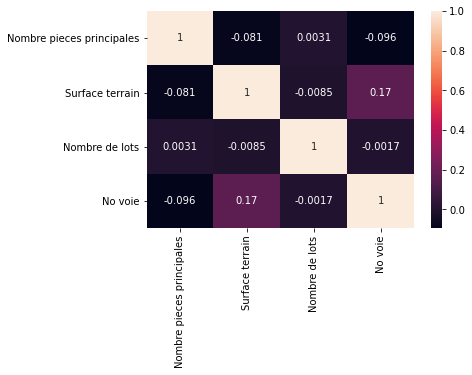

In [27]:
corrMatrix = filteredValeurs2019.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

array([[<AxesSubplot:title={'center':'Nombre pieces principales'}>]],
      dtype=object)

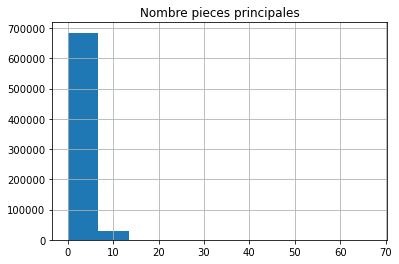

In [29]:
filteredValeurs2019.cumsum()
plt.figure()
df.plot()